# Data analysis and pre processing
This notebook explores the input data to perform feature engineering.

#### Libraries and options

In [1]:
import os
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pylab as plt

%matplotlib inline
sns.set_style("ticks")

pd.set_option('display.max_rows', 200)
pd.set_option('display.max_columns', 200)

In [2]:
def list_directory_tree_with_os_walk(starting_directory):
    for root, directories, files in os.walk(starting_directory):
        print(f"Directory: {root}")
        for file in files:
            print(f"  File: {file}")
# Check the directory
starting_directory_noe = 'C:/Users/NOE/source/repos/Energy-forecasting-NTNU/data/'
os.chdir(starting_directory_noe)

list_directory_tree_with_os_walk('.')

Directory: .
  File: .DS_Store
  File: Readme.md
  File: read_files.ipynb
  File: sample_submission.csv
  File: test.csv
Directory: .\.ipynb_checkpoints
  File: Data_exploration-checkpoint.ipynb
  File: Readme-checkpoint.md
  File: read_files-checkpoint.ipynb
Directory: .\A
  File: train_targets.parquet
  File: X_test_estimated.parquet
  File: X_train_estimated.parquet
  File: X_train_observed.parquet
Directory: .\B
  File: train_targets.parquet
  File: X_test_estimated.parquet
  File: X_train_estimated.parquet
  File: X_train_observed.parquet
Directory: .\C
  File: train_targets.parquet
  File: X_test_estimated.parquet
  File: X_train_estimated.parquet
  File: X_train_observed.parquet
Directory: .\catboost_info
  File: catboost_training.json
  File: learn_error.tsv
  File: time_left.tsv
Directory: .\catboost_info\learn
  File: events.out.tfevents
Directory: .\catboost_info\tmp
  File: cat_feature_index.4be58d7e-1d25b8d7-17fd0b0d-b7d319dc.tmp
Directory: .\Hugo
  File: notebook_hugo.ipy

## Data exploration

### Plot all the features
This only plots all the features for a given location. It can be pretty slow but helps to visualize the possible issues and pre-processing.

In [3]:
location = 'A'

train_target = pd.read_parquet(location+'/train_targets.parquet')
X_train_estimated = pd.read_parquet(location+'/X_train_estimated.parquet')
X_train_observed = pd.read_parquet(location+'/X_train_observed.parquet')
X_test_estimated = pd.read_parquet(location+'/X_test_estimated.parquet')

In [ ]:
features = X_train_observed.keys()[1:] 

# Plotting train target and all training features
fig, axs = plt.subplots(len(features)+1, 1, figsize=(20, 120), sharex=False)
fig.tight_layout(pad=5.0)
# Plot target
train_target[['time', 'pv_measurement']].set_index('time').plot(ax=axs[0], title='Target '+str(location), color='red')

for k,feature_name in enumerate(features):
    X_train_observed[['date_forecast', feature_name]].set_index('date_forecast').plot(ax=axs[k+1], title=feature_name, color='red')
    X_train_estimated[['date_forecast', feature_name]].set_index('date_forecast').plot(ax=axs[k+1], title=feature_name, color='blue')
plt.show()

### Correlation between features
To get a better understanding at the correlation between all features we will show the correlation matrix. We will then remove the features that have high correlation coefficient as they would only make the model more complex without providing extra information:
- __correlation coefficient = 1__ : the two features are exactly the same (to a scale factor). This can be seen for all the pressure features. Only one feature should be kept
- __correlation coefficient > 0.9__ : the features are highly correlated, and contain almost identical values. This can be seen for `dew_point` and `absolute_humidity` for example. Keeping only one of the two should be enough for the model.
- __correlation coefficient < 0__ : the two features evolve in oposite directions (one goes down when the other increases). It can be seen for the features `is_in_shadow` and `sun_elevation` for example.
- __correlation coefficient = `NaN`__ : calculation failed, there is probably missing data.

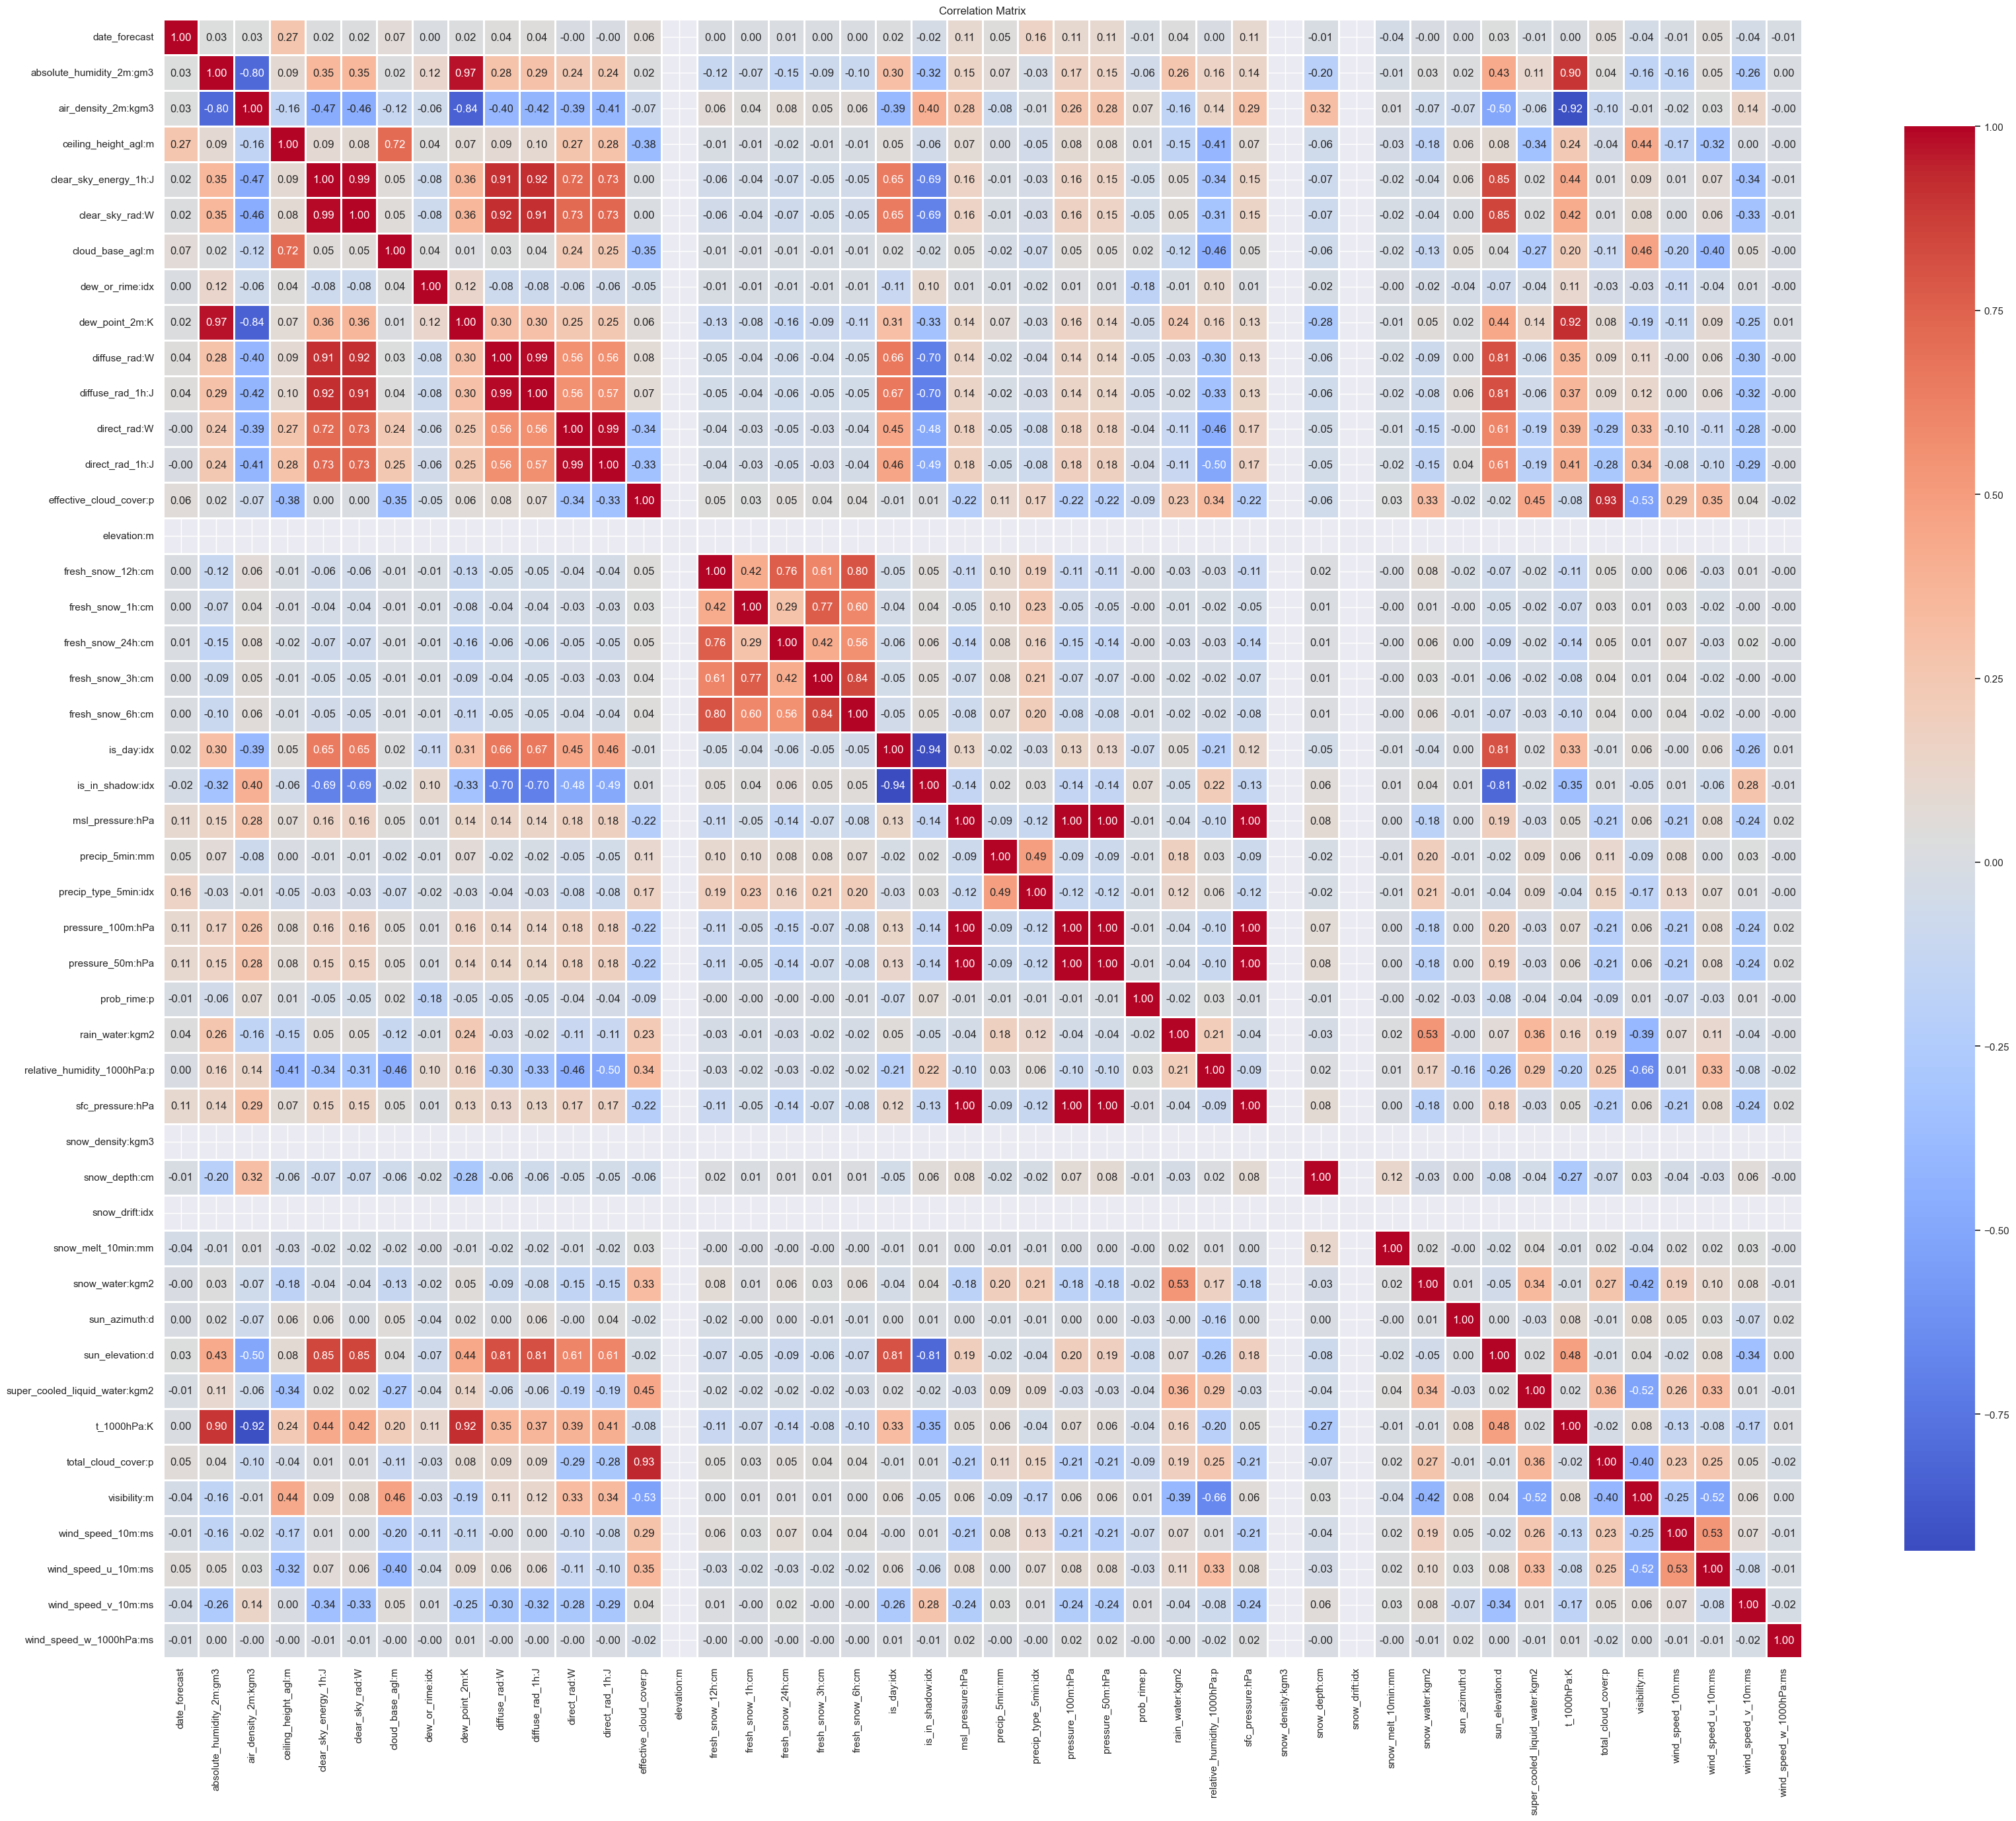

In [3]:
location = 'A'

train_target = pd.read_parquet(location+'/train_targets.parquet')
X_train_estimated = pd.read_parquet(location+'/X_train_estimated.parquet')
X_train_observed = pd.read_parquet(location+'/X_train_observed.parquet')
X_test_estimated = pd.read_parquet(location+'/X_test_estimated.parquet')


# The data to plot
df = X_train_observed   

# Exclude the first column (date forecast, it's the time axis)
columns_to_include = df.columns[:]

# Calculate the correlation matrix for selected columns
correlation_matrix = df[columns_to_include].corr()

# Set up the Seaborn heatmap
plt.figure(figsize=(40, 40))
sns.set(font_scale=1)      # Adjust the font scale

# Set up the Seaborn heatmap
sns.heatmap(
    correlation_matrix,
    annot=True,
    cmap='coolwarm',
    linewidths=1,
    square=True,
    cbar_kws={"shrink": 0.7},
    fmt='.2f'
)

plt.title("Correlation Matrix")
plt.show()

We will now focus on removing the highly correlated features. For that, we use the following function :

In [3]:
def find_low_correlation_columns(dataframe, threshold, verbose = True):
    
    correlation_matrix = dataframe[:].corr()

    feature_list = list(correlation_matrix.columns)
    removed_list = []
    for reference_index in range(len(feature_list)):
        reference_feature = feature_list[reference_index]

        # Check if this feature has not already been removed
        if reference_feature not in removed_list:
            for compared_index in range(reference_index+1,len(feature_list)):
                compared_feature = feature_list[compared_index]

                # Check if this feature has not already been removed
                if compared_feature not in removed_list:

                    # Get correlation coefficient
                    coefficient = correlation_matrix.loc[reference_feature,compared_feature]

                    # Remove column if it's a NaN
                    if pd.isna(coefficient):
                        removed_list.append(compared_feature)
                        if verbose : print(f"Removed {compared_feature} because it is NaN")
                        
                    # Remove if it is above threshold
                    if np.abs(coefficient)>=threshold:
                        removed_list.append(compared_feature)
                        if verbose : print(f"Removed \t{compared_feature}\tbecause it is correlated to\t{reference_feature}")
    
    
    output_list = feature_list.copy()
    for element in removed_list:
        output_list.remove(element)
        
    return list(output_list)

Removed elevation:m because it is NaN
Removed snow_density:kgm3 because it is NaN
Removed snow_drift:idx because it is NaN
Removed 	dew_point_2m:K	because it is correlated to	absolute_humidity_2m:gm3
Removed 	t_1000hPa:K	because it is correlated to	absolute_humidity_2m:gm3
Removed 	clear_sky_rad:W	because it is correlated to	clear_sky_energy_1h:J
Removed 	diffuse_rad:W	because it is correlated to	clear_sky_energy_1h:J
Removed 	diffuse_rad_1h:J	because it is correlated to	clear_sky_energy_1h:J
Removed 	direct_rad_1h:J	because it is correlated to	direct_rad:W
Removed 	total_cloud_cover:p	because it is correlated to	effective_cloud_cover:p
Removed 	is_in_shadow:idx	because it is correlated to	is_day:idx
Removed 	pressure_100m:hPa	because it is correlated to	msl_pressure:hPa
Removed 	pressure_50m:hPa	because it is correlated to	msl_pressure:hPa
Removed 	sfc_pressure:hPa	because it is correlated to	msl_pressure:hPa
32 features remaining


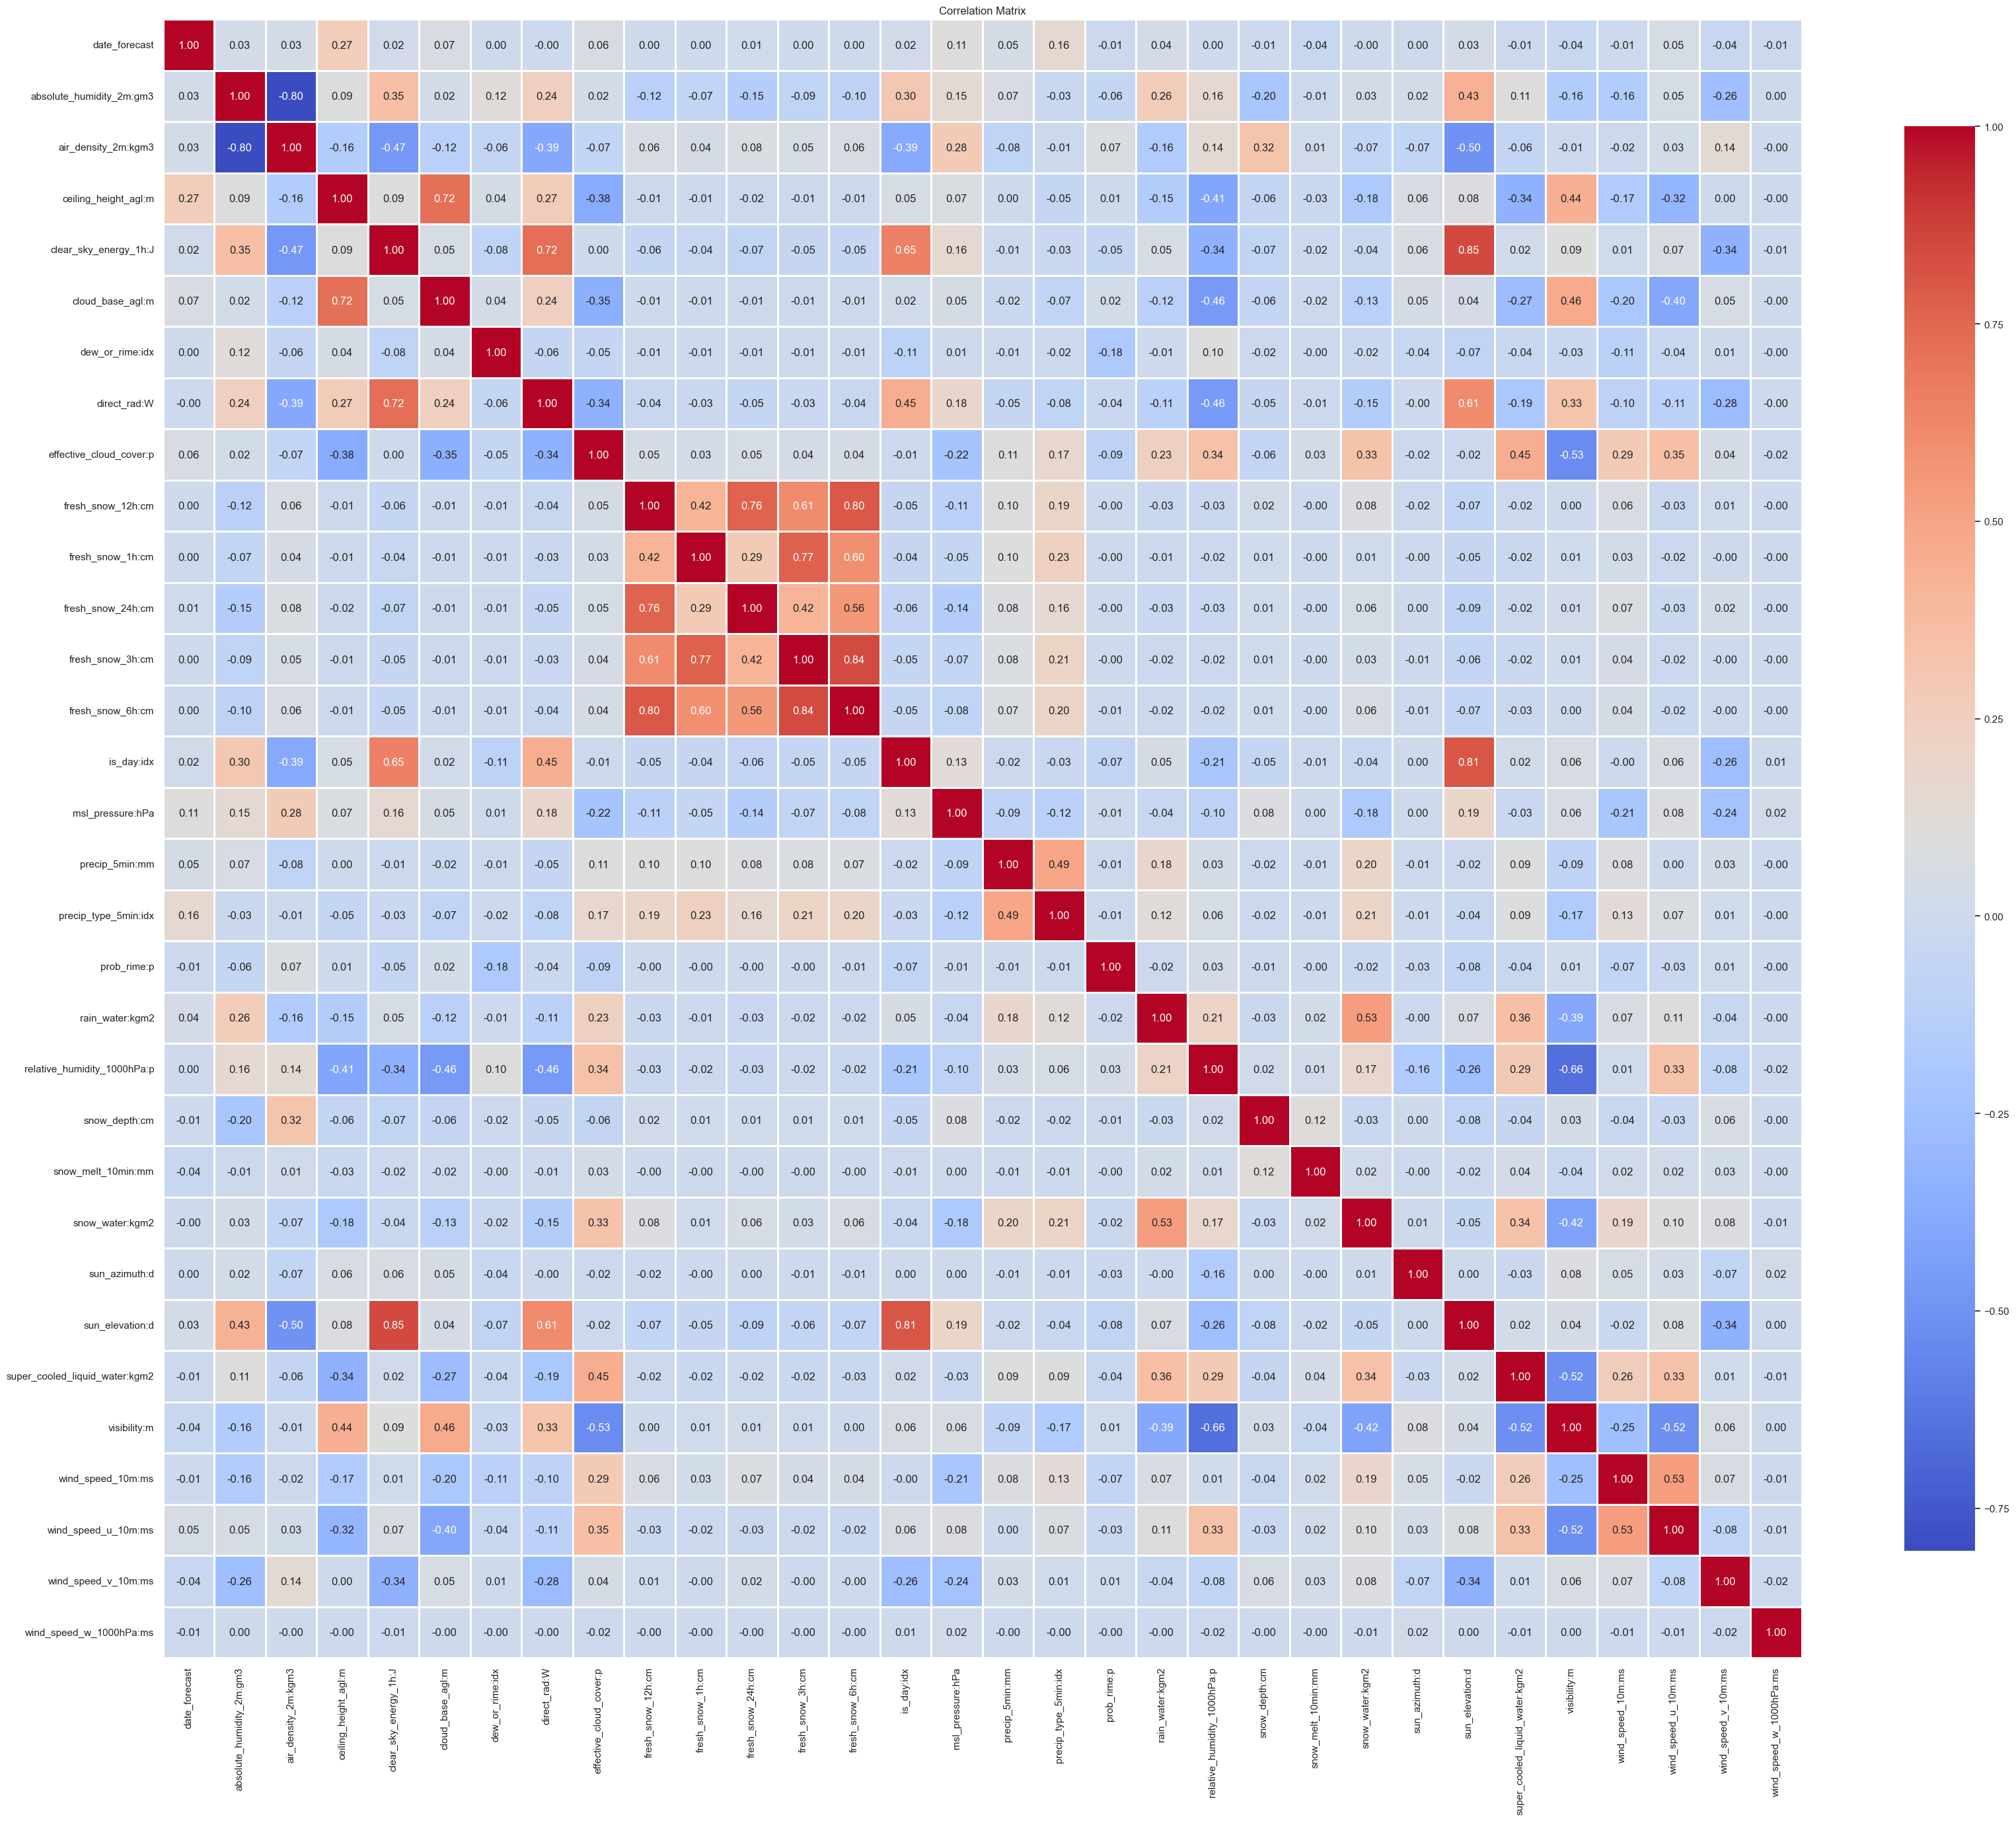

In [5]:
features = find_low_correlation_columns(X_train_observed,threshold=0.9)
print(f"{len(features)} features remaining")


# We now compute another correlation matrix to make sure that we excluded the correct features
# Select the non correlated features
columns_to_include = list(features)

# Calculate the correlation matrix for selected columns
correlation_matrix_filtered = df[columns_to_include].corr()

# Set up the Seaborn heatmap
plt.figure(figsize=(40, 40))
sns.set(font_scale=1)      # Adjust the font scale

# Set up the Seaborn heatmap
sns.heatmap(
    correlation_matrix_filtered,
    annot=True,
    cmap='coolwarm',
    linewidths=1,
    square=True,
    cbar_kws={"shrink": 0.7},
    fmt='.2f'
)

plt.title("Correlation Matrix")
plt.show()

There are still `NaN` values in the data (both features and target data) that we need to replace.

In [4]:
# Imput missing values fill with last valid observation
def fill_nan(Dataframe, feature):
    it_na = np.where(Dataframe[feature].isna())[0]
    
    #If missing value
    if len(it_na != 0):
        print("Missing data in",feature," size ",it_na.size," out of", Dataframe.shape[0])
        new_column = Dataframe[feature].fillna(method='ffill')
        method = 'ffill'
        
        if((np.any(new_column.isna()) == True)): 
            method = 'bfill'
            new_column = Dataframe[feature].fillna(method='bfill')
           
        #plt.plot(new_column)
        #plt.scatter(it_na,new_column[it_na],s=10, c='red')
    
        if (np.any(new_column.isna()) == False):
            print("Filled with",method,"method")
            Dataframe[feature] = new_column
        else:
            print("Still Nan values")
    #else : print("No NaN values in " + feature)

In [5]:
location = 'A'

train_target = pd.read_parquet(location+'/train_targets.parquet')
X_train_observed = pd.read_parquet(location+'/X_train_observed.parquet')
X_train_estimated = pd.read_parquet(location+'/X_train_estimated.parquet')
X_test_estimated = pd.read_parquet(location+'/X_test_estimated.parquet')


dataframes = [train_target,X_train_observed,X_train_estimated,X_test_estimated]
dataframe_names = ["train_target","X_train_observed","X_train_estimated","X_test_estimated"]
index = 0
FEATURES = [] # Contains the list of useful features for each dataframe

threshold = 0.9

for dataframe in dataframes:
    print("** WORKING ON "+dataframe_names[index]+"**")
    features = find_low_correlation_columns(dataframe,threshold,verbose=False)
    FEATURES.append(features)
    for feature in features:
        fill_nan(dataframe,feature)
    index+=1

** WORKING ON train_target**
** WORKING ON X_train_observed**
Missing data in ceiling_height_agl:m  size  22247  out of 118669
Filled with ffill method
Missing data in cloud_base_agl:m  size  8066  out of 118669
Filled with ffill method
** WORKING ON X_train_estimated**
Missing data in ceiling_height_agl:m  size  3919  out of 17576
Filled with ffill method
Missing data in cloud_base_agl:m  size  2094  out of 17576
Filled with ffill method
** WORKING ON X_test_estimated**
Missing data in ceiling_height_agl:m  size  793  out of 2880
Filled with ffill method
Missing data in cloud_base_agl:m  size  298  out of 2880
Filled with ffill method


C:\Users\NOE\AppData\Local\Temp\ipykernel_14636\633608867.py:8: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  new_column = Dataframe[feature].fillna(method='ffill')


## Train a simple model on the extracted features
Now that we have eliminated some "useless" features, we can try to train a basic model on the observed data to see how it performs.

There are a few manipulations to do in order to select the correct training data. First, we have different time resolutions:

- `X_train_observed` and `X_train_estimated` have a 15 minute time resolution.
- `train_target` has a 1h time resolution



In [20]:
YData = train_target
XTrain = pd.concat([X_train_observed])[FEATURES[1]]

# Make sure that the dates are in the correct order
YData.sort_values(by="time", inplace=True)
XTrain.sort_values(by="date_forecast", inplace=True)

# Now, we have to interpolate YData_selected to match the time interval of XData_selected
# First, ensure "time" column in YData_selected is in datetime format
YData['time'] = pd.to_datetime(YData['time'])
YData.set_index('time', inplace=True)
# Resample with a 15 minute time interval
YData_resampled = YData.resample('15T').interpolate(method='nearest') #  use 'linear' for better interpolation
YData_resampled = YData_resampled.reset_index()



# Extract the start and end dates from YData
start_date_Y = YData_resampled["time"].min()
end_date_Y = YData_resampled["time"].max()

# Extract the start and end dates from XData
start_date_X = XTrain["date_forecast"].min()
end_date_X = XTrain["date_forecast"].max()

# Only select dates where we have data for X and Y
start_date = max(start_date_Y,start_date_X)
end_date = min(end_date_Y,end_date_X)

# Select XData within the specified date range
XData_selected = XTrain[(XTrain["date_forecast"] >= start_date) & (XTrain["date_forecast"] <= end_date)]
YData_selected = YData_resampled[(YData_resampled["time"] >= start_date) & (YData_resampled["time"] <= end_date)]

XData_selected = XData_selected.drop(columns='date_forecast')
YData_selected = YData_selected['pv_measurement']

# Replace colons in the feature names
XData_selected.columns = [column.replace(":","_") for column in XData_selected.columns]

We can now train the light gbm model

In [9]:
import lightgbm as lgb
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split

RANDOM_SEED = 42

In [21]:
# Split dataset in train and test
X_train, X_test, Y_train, Y_test = train_test_split(XData_selected,YData_selected,
                                                    test_size=0.2,
                                                    random_state=RANDOM_SEED,
                                                    shuffle=True)


In [31]:
# Convert data to LightGBM Dataset format
train_data = lgb.Dataset(X_train, label=Y_train)
test_data = lgb.Dataset(X_test, label=Y_test)

# Set LightGBM hyperparameters
params = {
    "objective": "regression",
    "metric": "mse",
    "num_leaves": 1000,
    "learning_rate": 0.05,
}

# Train the LightGBM model
model = lgb.train(params, train_data, num_boost_round=1000)

# Make predictions
y_pred = model.predict(X_test, num_iteration=model.best_iteration)

# Evaluate the model
mse = mean_squared_error(Y_test, y_pred)
print(f"Mean Squared Error: {mse:.0f}")

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.009919 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 4182
[LightGBM] [Info] Number of data points in the train set: 94935, number of used features: 30
[LightGBM] [Info] Start training from score 674.676429
Mean Squared Error: 48957


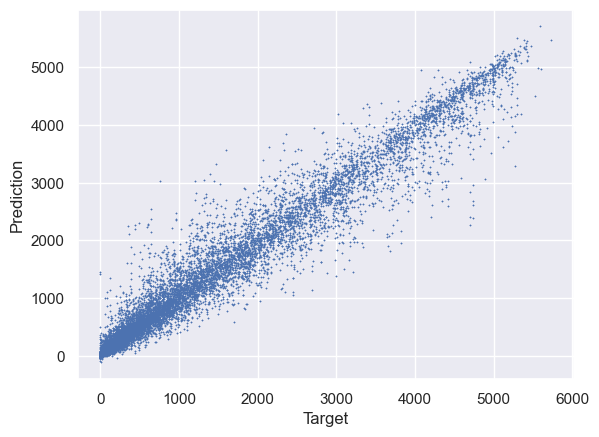

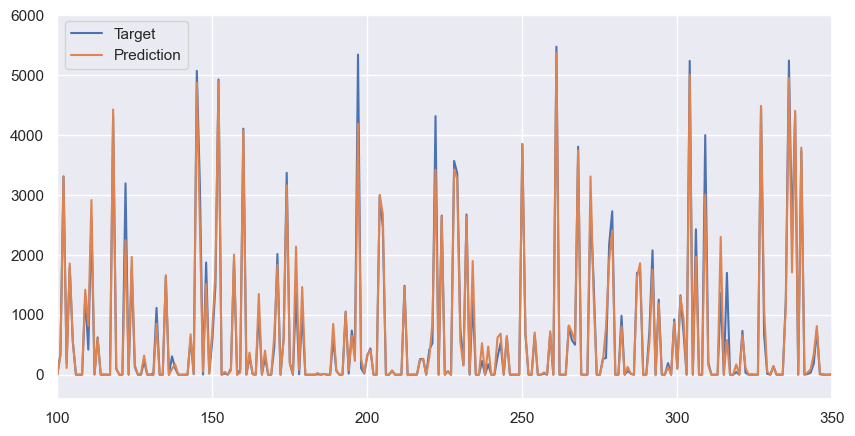

In [35]:
plt.figure()
plt.scatter(Y_test,y_pred,s=0.05,c="b",marker="*",)
plt.xlabel("Target")
plt.ylabel("Prediction")
plt.show()

plt.figure(figsize=(10, 5))
x = np.arange(0,len(Y_test))
plt.plot(x,Y_test, label = 'Target')
plt.plot(x,y_pred, label = 'Prediction')
plt.legend()
plt.xlim([100, 350])
plt.show()

This model is pretty dumb as there is no time awareness (using previous data), it is just regression on a vector. Also, we are only training using the observed data and not the forecasted one so it's not quite what we wanted. We will now use a sliding window

In [26]:
from sklearn.model_selection import TimeSeriesSplit

# Define your sliding window configuration
window_size = 4*1000  # The past 1000 hours
step_size = 4*500     # Move 500 hours forward

# Create TimeSeriesSplit with sliding window
tscv = TimeSeriesSplit(n_splits=(len(XData_selected) - window_size) // step_size + 1)

mse_scores = []

for train_index, test_index in tscv.split(XData_selected):
    # Extract the current window for training and testing
    train_indices = range(train_index[0], train_index[-1] + 1)
    test_indices = range(test_index[0], test_index[-1] + 1)

    X_train = XData_selected.iloc[train_indices]
    X_test = XData_selected.iloc[test_indices]
    Y_train = YData_selected.iloc[train_indices]
    Y_test = YData_selected.iloc[test_indices]

    # Convert data to LightGBM Dataset format
    train_data = lgb.Dataset(X_train, label=Y_train)
    test_data = lgb.Dataset(X_test, label=Y_test)

    # Set LightGBM hyperparameters
    params = {
        "objective": "regression",
        "metric": "mse",
        "num_leaves": 500,
        "learning_rate": 0.05,
    }

    # Train the LightGBM model
    model = lgb.train(params, train_data, num_boost_round=100)

    # Make predictions
    y_pred = model.predict(X_test, num_iteration=model.best_iteration)

    # Evaluate the model
    mse = mean_squared_error(Y_test, y_pred)
    mse_scores.append(mse)

# Calculate the mean MSE across all sliding windows
mean_mse = sum(mse_scores) / len(mse_scores)
print(f"Mean Squared Error (across sliding windows): {mean_mse:.0f}")

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000859 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2988
[LightGBM] [Info] Number of data points in the train set: 2031, number of used features: 22
[LightGBM] [Info] Start training from score 1153.849845
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gai

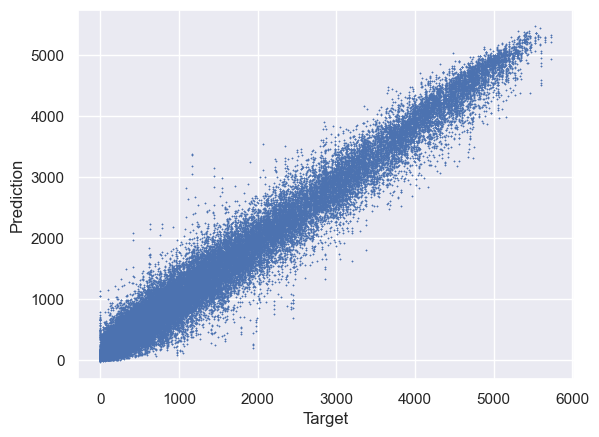

In [27]:
y_pred = model.predict(XData_selected, num_iteration=model.best_iteration)

plt.figure()
plt.scatter(YData_selected,y_pred,s=0.05,c="b",marker="*",)
plt.xlabel("Target")
plt.ylabel("Prediction")
plt.show()

This is slower and has a higher MSE, not very good.

## New approach to feature engineering

Previously we oversampled the target values to match the time sampling of `Xtrain`. This is not optimal. Now, we will focus on merging the different training datasets and selecting only the `YData` where we have a matching `XData` time value.

We will also try to match each YData element to 4 elements of `XData` (the ones corresponding to the entire hour)

In [8]:
YData = train_target

# Concatenate X_train datasets
# drop last row because it is not a multiple of 4
XTrain = pd.concat([X_train_observed[:-1], X_train_estimated])[FEATURES[1]]

# Replace ":" by "_" in columns names to avoid errors
XTrain.columns = [column.replace(":","_") for column in XTrain.columns]

# Create a set of unique 'date_forecast' values from XTrain
xtrain_times = set(XTrain['date_forecast'])

# Filter YData to only keep rows with matching 'time' in XTrain
YTrain = YData[YData['time'].isin(xtrain_times)]

# Make sure we have the correct number of rows. Should be 4
print(XTrain.shape[0]/YTrain.shape[0])

# Extract the start and end dates from YData
start_date_Y = YTrain["time"].min()
end_date_Y = YTrain["time"].max()

# Extract the start and end dates from XData
start_date_X = XTrain["date_forecast"].min()
end_date_X = XTrain["date_forecast"].max()

print(f"XTrain dates :\nstart:{start_date_X}\tend:{end_date_X}\n")
print(f"YTrain dates :\nstart:{start_date_Y}\tend:{end_date_Y}")
print(f"\n{len(XTrain)/4}")
print(f"\n{len(YTrain)}")

4.0
XTrain dates :
start:2019-06-02 22:00:00	end:2023-04-30 23:45:00

YTrain dates :
start:2019-06-02 22:00:00	end:2023-04-30 23:00:00

34061.0

34061


We can now try to divide `XTrain` in subsets of 4 elements to match the time sampling of `YTrain`. With this approach, each element of YTrain will correspond to a matrix of size $(n,4)$ where $n$ is the number of features

In [22]:
### PROOF OF CONCEPT /// fuck for loops version
# We get a numpy array at the end but it should be ok

N = 20
smol_df = XTrain[0:4*N]
smol_target = YTrain[0:N]

smol_df_reshaped = np.reshape(smol_df.to_numpy(), newshape=(N,4,len(FEATURES[1])))
smol_df_reshaped.shape

(20, 4, 32)

In [9]:
XTrain_reshaped = np.reshape(XTrain.to_numpy(), newshape=(len(YTrain),4,len(FEATURES[1])))
XTrain_reshaped.shape

# Remove timestamp data
XTrain_reshaped = XTrain_reshaped[:,:,1:]

We can now try to train the same light gbm on this new data

In [11]:
import lightgbm as lgb
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
from sklearn.neural_network import MLPRegressor

RANDOM_SEED = 42

In [12]:
# flatten each matrix in a vector
XTrain_flat = np.reshape(XTrain_reshaped,newshape=(XTrain_reshaped.shape[0],-1))
# Split dataset in train and test
X_train, X_test, Y_train, Y_test = train_test_split(XTrain_flat,YTrain['pv_measurement'],
                                                    test_size=0.2,
                                                    random_state=RANDOM_SEED,
                                                    shuffle=True)

### MLP regression (bad)

Iteration 1, loss = 84912982.26017821
Iteration 2, loss = 847058.91832291
Iteration 3, loss = 484306.59755311
Iteration 4, loss = 391074.73916937
Iteration 5, loss = 345493.44736362
Iteration 6, loss = 311812.57790841
Iteration 7, loss = 278436.09367933
Iteration 8, loss = 251427.10988489
Iteration 9, loss = 232831.34075049
Iteration 10, loss = 216295.10711130
Iteration 11, loss = 208734.10568334
Iteration 12, loss = 199767.94803200
Iteration 13, loss = 193619.52939568
Iteration 14, loss = 184625.17682250
Iteration 15, loss = 180687.35072183
Iteration 16, loss = 176913.37631595
Iteration 17, loss = 176384.83656384
Iteration 18, loss = 176375.97057199
Iteration 19, loss = 171635.45449853
Iteration 20, loss = 170385.85769152
Iteration 21, loss = 180592.75305178
Iteration 22, loss = 166966.62370482
Iteration 23, loss = 161127.38419208
Iteration 24, loss = 162354.86420025
Iteration 25, loss = 169392.53443205
Iteration 26, loss = 162869.65587251
Iteration 27, loss = 159334.11181048
Iteratio

c:\Users\NOE\source\repos\Energy-forecasting-NTNU\ML_Project\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (5000) reached and the optimization hasn't converged yet.
  warnings.warn(


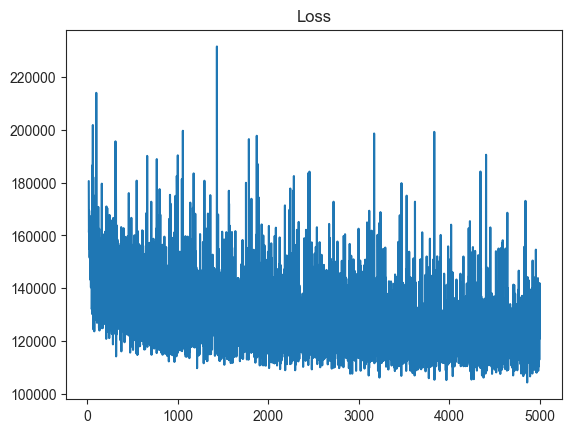

In [70]:
# Use a MLP for regression
model = MLPRegressor(random_state=1,
                     learning_rate_init=0.0001,
                     learning_rate="invscaling",
                     max_iter=5000,
                     n_iter_no_change=5000,
                     tol=1e-6,
                     warm_start=True,
                     verbose=True)
model.fit(X_train, Y_train)

plt.figure()
start_iter = 20
plt.plot(np.arange(start_iter,model.n_iter_),model.loss_curve_[start_iter:])
plt.title("Loss")
plt.show()

In [71]:
# Make predictions
y_pred = model.predict(X_test)

# Evaluate the model
mse = mean_squared_error(Y_test, y_pred)
print(f"Mean Squared Error: {mse:.0f}")

Mean Squared Error: 226088


In [ ]:
plt.figure()
plt.scatter(Y_test,y_pred,s=0.05,c="b",marker="*",)
plt.xlabel("Target")
plt.ylabel("Prediction")
plt.show()

plt.figure(figsize=(10, 5))
x = np.arange(0,len(Y_test))
plt.plot(x,Y_test, label = 'Target')
plt.plot(x,y_pred, label = 'Prediction')
plt.legend()
plt.xlim([100, 350])
plt.show()

### LGB regression (bad)

In [73]:
import lightgbm as lgb
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split

RANDOM_SEED = 42

In [74]:
# Convert data to LightGBM Dataset format
train_data = lgb.Dataset(X_train, label=Y_train)
test_data = lgb.Dataset(X_test, label=Y_test)

# Set LightGBM hyperparameters
params = {
    "objective": "regression",
    "metric": "mse",
    "num_leaves": 1000,
    "learning_rate": 0.05,
}

# Train the LightGBM model
model = lgb.train(params, train_data, num_boost_round=1000)

# Make predictions
y_pred = model.predict(X_test, num_iteration=model.best_iteration)

# Evaluate the model
mse = mean_squared_error(Y_test, y_pred)
print(f"Mean Squared Error: {mse:.0f}")

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.029191 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 15585
[LightGBM] [Info] Number of data points in the train set: 27248, number of used features: 120
[LightGBM] [Info] Start training from score 635.052494
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive g

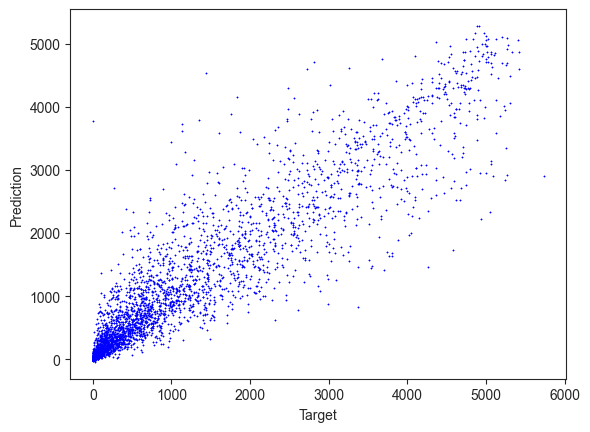

In [75]:
plt.figure()
plt.scatter(Y_test,y_pred,s=0.05,c="b",marker="*",)
plt.xlabel("Target")
plt.ylabel("Prediction")
plt.show()

#plt.figure(figsize=(10, 5))
#x = np.arange(0,len(Y_test))
#plt.plot(x,Y_test, label = 'Target')
#plt.plot(x,y_pred, label = 'Prediction')
#plt.legend()
#plt.xlim([100, 350])
#plt.show()

### CatBoost regression

In [13]:
from catboost import CatBoostRegressor
from sklearn.metrics import mean_squared_error, r2_score

Train the model

In [32]:
model = CatBoostRegressor(iterations=5000,
                          learning_rate=0.5,
                          depth=11,
                          loss_function='RMSE')

model.fit(X_train, Y_train)

0:	learn: 748.1201653	total: 190ms	remaining: 15m 50s
1:	learn: 569.7820954	total: 365ms	remaining: 15m 13s
2:	learn: 496.9479686	total: 646ms	remaining: 17m 55s
3:	learn: 467.7226262	total: 850ms	remaining: 17m 41s
4:	learn: 449.7968424	total: 1.1s	remaining: 18m 24s
5:	learn: 433.8541544	total: 1.34s	remaining: 18m 34s
6:	learn: 423.8247141	total: 1.6s	remaining: 18m 58s
7:	learn: 416.0282152	total: 1.83s	remaining: 19m 5s
8:	learn: 410.9708148	total: 2.05s	remaining: 18m 57s
9:	learn: 407.4685076	total: 2.28s	remaining: 18m 56s
10:	learn: 399.3728177	total: 2.5s	remaining: 18m 54s
11:	learn: 391.9750435	total: 2.73s	remaining: 18m 53s
12:	learn: 388.5046173	total: 2.94s	remaining: 18m 49s
13:	learn: 384.8394086	total: 3.16s	remaining: 18m 46s
14:	learn: 377.9208106	total: 3.38s	remaining: 18m 43s
15:	learn: 374.5567880	total: 3.62s	remaining: 18m 49s
16:	learn: 369.6938041	total: 3.84s	remaining: 18m 44s
17:	learn: 366.1342798	total: 4.05s	remaining: 18m 42s
18:	learn: 363.9187777	t

Test the model

MSE = 8
R2 = 1


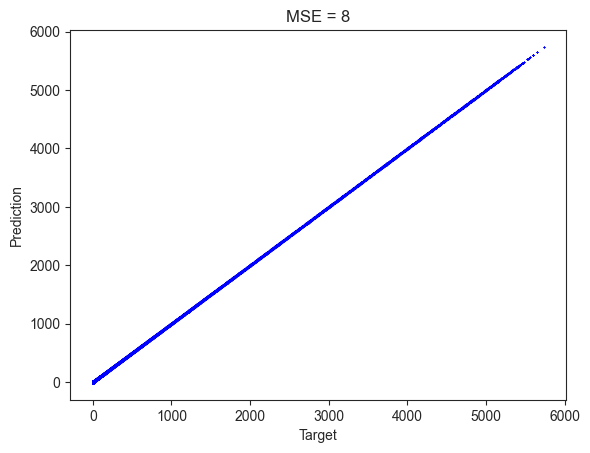

In [36]:
predictions = model.predict(X_train)

mse = mean_squared_error(Y_train, predictions)
r2 = r2_score(Y_train, predictions)

print(f"MSE = {mse:.0f}")
print(f"R2 = {r2:.0f}")

plt.figure()
plt.scatter(Y_train,predictions,s=0.05,c="b",marker="*",)
plt.xlabel("Target")
plt.ylabel("Prediction")
plt.title(f"MSE = {mse:.0f}")
plt.show()

L'imbécile est en train d'overfit

In [27]:
feature_importance = model.get_feature_importance(prettified=True)
print(feature_importance)

                        Feature Id  Importances
0                     direct_rad_W    20.448551
1                  sun_elevation_d    11.649865
2                    sun_azimuth_d    10.526960
3                 msl_pressure_hPa     7.005504
4         absolute_humidity_2m_gm3     5.548198
5            clear_sky_energy_1h_J     5.244447
6              wind_speed_u_10m_ms     5.162415
7             ceiling_height_agl_m     4.848404
8          effective_cloud_cover_p     4.383916
9              air_density_2m_kgm3     4.140887
10             wind_speed_v_10m_ms     4.027412
11     relative_humidity_1000hPa_p     3.595580
12                cloud_base_agl_m     3.493713
13                    visibility_m     3.489599
14               wind_speed_10m_ms     3.468900
15                 snow_water_kgm2     0.813681
16  super_cooled_liquid_water_kgm2     0.799902
17            precip_type_5min_idx     0.373651
18                      is_day_idx     0.335379
19                  precip_5min_mm     0